_Cuál es la trayectoria actual de incendios en Santa Cruz?_

Construyo un gráfico de incendios diarios acumulados hasta el día de hoy y lo comparo con las series de años pasados. Cómo se compara la situación actual con 2019? En este gráfico utilizo datos del sistema SNPP-VIIRS, que puedes solicitar via [este formulario](https://firms.modaps.eosdis.nasa.gov/download/create.php). Descargué un archivo con datos diarios desde 2012 hasta fines de 2021 y otro con datos al día durante 2022, que en total pesan más de 170 MB.

In [1]:
%%sh
echo "El peso de cada csv que descargué:\n"
du -h data/viirs* | sort -nr

El peso de cada csv que descargué:

168M	data/viirs_historical.csv
5.2M	data/viirs_2022.csv


In [91]:
import datetime as dt
import locale

import datashader as ds
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datashader.utils import export_image
from IPython.display import Markdown, display
from matplotlib import cm, colors, dates, ticker
from scipy.interpolate import pchip

locale.setlocale(locale.LC_TIME, "es_US.UTF8")
plt.style.use("../0_common/estilo.mplstyle");

Estos datos incluyen incendios en toda Bolivia. Para separar sólo aquellos incendios que ocurren en un departamento debo cargar un mapa con límites departamentales. Encuentro uno rápidamente con el [catálogo de datos geográficos](https://mauforonda.github.io/geodatos/) que mantengo, lo simplifico un poco y lo guardo.

In [5]:
DEPARTAMENTOS_GEOBOLIVIA = "https://geo.gob.bo/geoserver/ows?service=WFS&request=GetFeature&typeName=fondos:Departamento_2015&outputFormat=application/json"

departamentos = gpd.read_file(DEPARTAMENTOS_GEOBOLIVIA)
departamentos["geometry"] = departamentos["geometry"].simplify(tolerance=0.01)
departamentos.to_file("datos/departamentos.geojson")

Así en el futuro puedo sólo recargar este mapa:

In [65]:
departamentos = gpd.read_file("data/departamentos.geojson")

Cargo todos los incendios desde 2012 hasta el día de hoy en el mismo sistema de coordenadas de los límites departamentales.

In [66]:
def carga_incendios_csv(csv, crs):
    """
    Carga un csv con incendios como geodataframe con el
    sistema de coordenadas (crs) especificado
    """

    fires = pd.read_csv(csv, low_memory=False)
    fires = gpd.GeoDataFrame(
        fires, geometry=gpd.points_from_xy(fires.longitude, fires.latitude), crs=crs
    )
    fires["acq_date"] = pd.to_datetime(fires.acq_date, format="%Y-%m-%d")
    return fires

In [4]:
incendios = pd.concat(
    [
        carga_incendios_csv("data/{}.csv".format(f), departamentos.crs)
        for f in ["viirs_historical", "viirs_2022"]
    ]
)

In [9]:
display(
    Markdown(
        "Existen {} incendios detectados y cada registro tiene esta forma:".format(
            len(incendios)
        )
    )
)
incendios.sample(1)

Existen 2193869 incendios detectados y cada registro tiene esta forma:

latitude  longitude  bright_ti4  scan  track   acq_date  acq_time  \
967610 -12.440424 -66.413048      345.49  0.47    0.4 2017-12-22      1811   

       satellite instrument confidence version  bright_ti5   frp daynight  \
967610         N      VIIRS          n       1      295.72  9.27        D   

        type                     geometry  brightness  bright_t31  
967610   0.0  POINT (-66.41305 -12.44042)         NaN         NaN

Puedes encontrar una descripción de cada campo [acá](https://www.earthdata.nasa.gov/learn/find-data/near-real-time/firms/viirs-i-band-375-m-active-fire-data).

Podría filtrar incendios dentro de cualquier departamento

In [129]:
Markdown(
    "_Departamentos_: "
    + ", ".join(
        departamentos[departamentos.DESCRIPCIO == "Departamento"].DEPARTAMEN.tolist()
    )
)

_Departamentos_: Cochabamba, Potosí, Chuquisaca, Tarija, Santa Cruz, Pando, Oruro, Beni, La Paz

En este caso selecciono Santa Cruz

In [67]:
def filter_incendios(departamento):

    return gpd.sjoin(
        incendios,
        departamentos[departamentos.DEPARTAMEN == departamento],
        how="inner",
        predicate="within",
    )

In [68]:
santacruz = filter_incendios("Santa Cruz")

Construyo una tabla con el número diario de incendios en Santa Cruz para cada día, y una columna para cada año para realizar gráficos y comparaciones fácilmente. En este caso utilizo todos los incendios detectados, pero podría seleccionar sólo aquellos sobre un nivel de confianza o cualquier otro criterio utilizando los campos disponibles.

In [97]:
def daily_fires(incendios_dataframe):
    """
    Agrupa incendios por día y crea una columna para cada año.
    """

    incendios_dataframe["year"] = incendios_dataframe.acq_date.dt.year
    incendios_dataframe["date"] = [
        d.replace(year=2000) for d in incendios_dataframe.acq_date
    ]
    incendios_diarios = (
        incendios_dataframe.groupby(
            ["date", "year", pd.Grouper(key="acq_date", freq="D")]
        )
        .size()
        .reset_index(name="incendios")
    )

    incendios_diarios = incendios_diarios.pivot_table(
        index="date", columns="year", values="incendios"
    )

    current_year = incendios_dataframe.year.max()
    other_years = [
        col
        for col in incendios_diarios.columns
        if col != incendios_dataframe.year.max()
    ]
    last_date = incendios_dataframe.acq_date.max().replace(year=2000)

    incendios_diarios = pd.concat(
        [
            incendios_diarios[other_years].fillna(0),
            incendios_diarios.loc[:last_date, current_year].fillna(0),
        ],
        axis=1,
    )

    return incendios_diarios

In [13]:
santacruz_diario = daily_fires(santacruz)

In [14]:
santacruz_diario

2012  2013   2014   2015   2016   2017   2018   2019   2020  \
date                                                                      
2000-01-01   0.0  14.0   38.0  146.0    8.0   89.0    1.0   32.0   11.0   
2000-01-02   0.0   0.0   41.0   44.0    6.0   43.0    2.0   36.0    8.0   
2000-01-03   0.0   7.0   72.0    0.0   25.0  101.0    0.0  120.0   59.0   
2000-01-04   0.0  41.0    4.0    9.0   13.0  192.0    8.0   38.0  213.0   
2000-01-05   0.0  31.0    0.0   27.0  140.0  156.0   11.0  140.0  199.0   
...          ...   ...    ...    ...    ...    ...    ...    ...    ...   
2000-12-27   5.0  90.0   50.0   28.0    9.0   33.0   36.0   64.0   40.0   
2000-12-28   0.0  78.0   78.0   82.0    2.0   48.0  107.0   46.0   32.0   
2000-12-29  15.0  38.0   44.0  220.0   69.0    5.0   56.0  108.0   71.0   
2000-12-30  11.0  29.0  196.0  164.0  157.0   44.0   92.0   68.0   85.0   
2000-12-31  27.0  33.0  241.0  130.0   86.0   19.0   51.0   30.0   14.0   

             2021   2022  
date                      
2000-01-01    7.0   40.0  
2000-01-02  125.0   52.0  
2000-01-03  268.0   97.0  
2000-01-04   53.0  126.0  
2000-01-05   78.0   12.0  
...           ...    ...  
2000-12-27   27.0    NaN  
2000-12-28   99.0    NaN  
2000-12-29  121.0    NaN  
2000-12-30  162.0    NaN  
2000-12-31  159.0    NaN  

[366 rows x 11 columns]

Finalmente construyo un gráfico con una línea para cada año. Cada elemento y transformación está comentada para dar una idea del proceso. Al diseñar esta función intento encontrar un balance entre parametrizar atributos que de otra forma parecerían demasiado arbitrarios y tener algo que pueda ser usado fácilmente en otra ocasión.

In [96]:
def plot_incendios(
    diarios,
    departamento_nombre="Santa Cruz",
    filename=None,
    last_day=None,
    credits={"datos": "SNPP - VIIRS", "diseño": "Mauricio Foronda"},
    cmap=colors.ListedColormap(cm.get_cmap("viridis")(np.linspace(0.2, 1.0, 255))),
    background="#0f283a",
    gridcolor="#4e6879",
    lightcolor="#e9e4cd",
    flamecolor="#ac321a",
):
    def smooth_dateline(serie, num=300):
        """
        Suaviza una serie, en tanto mayor sea `num`,
        más suave la línea.
        """
        s = serie.dropna()
        x_num = dates.date2num(s.index)
        x_smooth = np.linspace(x_num.min(), x_num.max(), num)
        spline = pchip(x_num, s)
        y_smooth = spline(x_smooth)
        return pd.Series(y_smooth, index=x_smooth)

    def spaced_annotations(yearend, years, min_spacing):
        """
        Resuelve casos donde las anotaciones de años
        se sobrelapan entre sí. `min_spacing` es el mínimo
        espacio vertical que debería existir entre anotaciones.
        """

        positions = pd.Series(yearend, index=years)
        for value, nextvalue, year, nextyear in zip(
            yearend, yearend[1:], years, years[1:]
        ):
            spacing = nextvalue - value
            if spacing < min_spacing:
                positions.loc[nextyear] += min_spacing - spacing
        return positions

    # la suma acumulativa dividida entre mil
    dcum = diarios.replace(np.nan, 0).cumsum() / 1e3

    # inicializo la figura y pinto el color de fondo
    f, ax = plt.subplots(1, 1, figsize=(8, 5), dpi=150)
    for i in [f, ax]:
        i.set_facecolor(background)

    # defino algunas variables útiles
    max_value = dcum.max().max()
    n_years = len(dcum.columns)  # el número de años
    current_year = dcum.columns[-1]  # el último año
    last_update = diarios.index[diarios.iloc[:, -1] > 0][-1]
    last_value = dcum.loc[last_update, current_year]
    ax_border = dt.date(2001, 1, 2)  # el borde derecho de la figura
    years_sort = dcum.iloc[:, :-1].tail(1).iloc[0].sort_values()
    annotation_positions = spaced_annotations(
        years_sort, years_sort.index, max_value / 35
    ).to_dict()  # las posiciones verticales de las anotaciones de año

    # dibujar la línea para cada año
    for i, year in enumerate(dcum.columns):
        if year != current_year:
            # definir la opacidad de la línea según cuán próxima sea al último año,
            # en tanto más próxima, más clara
            alpha = (i + 1) / (n_years + 3)
            yearserie = dcum[year]
        else:
            # si se trata del último año, dibujar la línea más clara
            # además almacenar la última fecha y valor para posicionar otras figuras
            alpha = 1.0
            yearserie = dcum.loc[:last_update, year]
        color = colors.to_hex(
            cmap(alpha)
        )  # el color es el valor de la opacidad en el mapa de colores
        smooth_year = smooth_dateline(yearserie)  # suavizar la serie del año
        ax.plot(
            smooth_year, color=color, linewidth=0.8, alpha=alpha
        )  # dibujar la figura suavizada

        # si se trata del año actual crear otras figuras encima
        # que hagan brillar a esta línea
        if year == current_year:
            # una línea casi transparente
            ax.plot(smooth_year, color=lightcolor, linewidth=1.2, alpha=0.2)
            # tres puntos que hagan una punta incandescente
            for dotcolor, dotsize, dotalpha in zip(
                [lightcolor, flamecolor, lightcolor], [40, 25, 15], [0.1, 0.3, 1.0]
            ):
                ax.scatter(
                    [last_update],
                    [last_value],
                    color=dotcolor,
                    alpha=dotalpha,
                    s=dotsize,
                    linewidth=0,
                    zorder=10,
                )

        # si no es el último año dibujar una anotación al final de la serie
        if year != current_year:
            annotation_x = ax_border
            annotation_y = annotation_positions[year]
            annotation_text = year
            ha = "left"
            annotation_color = color
        # si es el último año dibujar una anotación encima del último valor
        else:
            annotation_x = last_update
            annotation_y = last_value + (max_value / 10)
            if last_day == None:
                annotation_text = last_update.replace(year=year).strftime(
                    "%d de %B\nde %Y"
                )
            else:
                annotation_text = last_day
            ha = "right"
            annotation_color = lightcolor

        ax.annotate(
            annotation_text,
            xy=(annotation_x, annotation_y),
            ha=ha,
            va="center",
            color=annotation_color,
            fontsize=6,
        )

    # parámetros para los ticks, la reja y los límites horizontales
    ax.tick_params(labelsize=5)
    ax.xaxis.set_major_locator(dates.MonthLocator(bymonthday=15))
    ax.xaxis.set_major_formatter(dates.DateFormatter("%B"))
    ax.grid(color=gridcolor, axis="y")
    ax.set_xlim(dt.date(2000, 1, 1), dt.date(2001, 1, 2))

    # dibujar el título y los créditos
    # comenzar desde `top_title` y bajar `margin_title` con cada texto

    axt = ax.inset_axes([0.05, 0.5, 0.5, 0.4])
    axt.set_facecolor(background)
    axt.set_axis_off()

    top_title = 1.0
    margin_title = 0.06
    margin_credit = 0.05

    for text, fontsize in zip(
        ["incendios", "cumulativos", "en {}".format(departamento_nombre)], [23, 14, 23]
    ):
        annotation = axt.annotate(
            text.upper(),
            xy=(0.0, top_title),
            xycoords="axes fraction",
            fontweight="bold",
            fontsize=fontsize,
            ha="left",
            va="top",
            color=lightcolor,
        )
        annotation_coords = axt.transData.inverted().transform(
            annotation.get_window_extent(renderer=f.canvas.get_renderer())
        )
        top_title = annotation_coords[0][1] - margin_title
    # luego bajar 8 y hacer lo mismo para los créditos
    # pero en lugar de `margin_title`, usar `margin_credit` para espaciar
    # verticalmente textos

    top_title -= margin_title

    for cred in credits.keys():
        annotation = axt.annotate(
            cred,
            xy=(0, top_title),
            fontsize=7,
            ha="left",
            va="top",
            color=lightcolor,
        )
        annotation_coords = axt.transData.inverted().transform(
            annotation.get_window_extent(renderer=f.canvas.get_renderer())
        )
        axt.annotate(
            credits[cred],
            xy=(annotation_coords[1][0] + 0.015, top_title),
            xycoords="axes fraction",
            fontsize=7,
            ha="left",
            va="top",
            color=lightcolor,
            fontweight="bold",
        )
        top_title = annotation_coords[0][1] - margin_credit

    # algunos ajustes finales para ticks en el eje vertical
    # quitar el 0 abajo y poner un `mil` al lado del
    # último tick superior

    f.canvas.draw()
    labels = ax.get_yticklabels()
    labels = [i.get_text() for i in labels]
    ax.set_yticks(ax.get_yticks())
    ax.set_yticklabels(["", ""] + labels[2:-1] + [""])
    for label in ax.get_yticklabels():
        label.set_va("bottom")
    ax.set_ylim(bottom=-0.5)

    last_ytick = ax.get_yticks()[-2]
    ax.annotate(
        "mil",
        xy=(dt.datetime(2000, 1, 1), last_ytick),
        fontsize=5,
        ha="right",
        va="bottom",
        color="#88888f",
    )

    # finalmente, guardar todo en el `filename` que especifico, si existe alguno
    if filename != None:
        f.savefig(
            "plots/{}".format(filename), bbox_inches="tight", pad_inches=0.2, dpi=300
        )

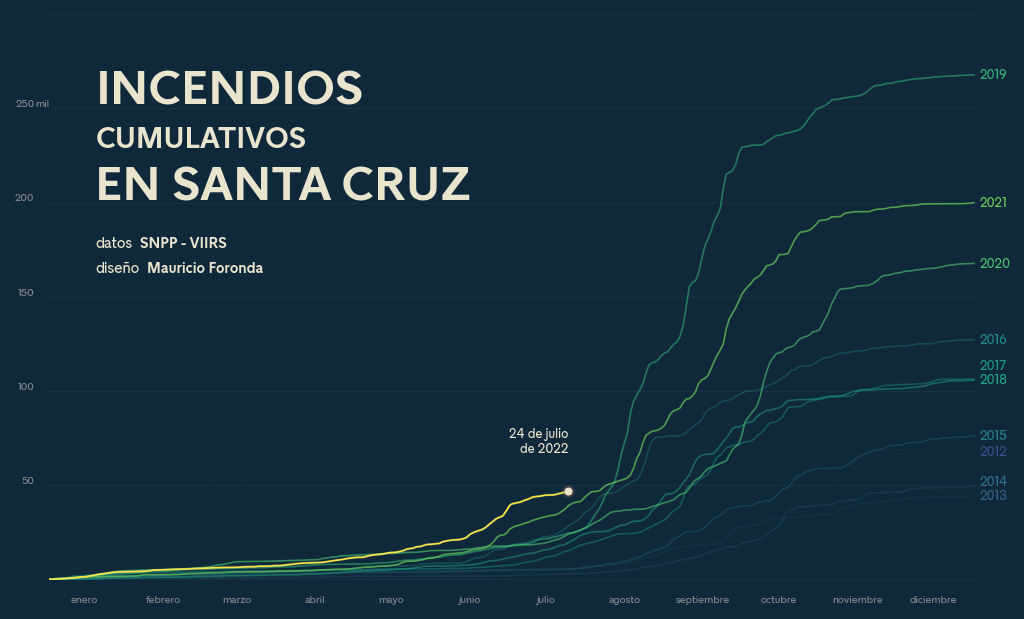

In [271]:
plot_incendios(santacruz_diario)

Para suavizar cada línea mejor podría agrupar el número de incendios por semana:

In [22]:
santacruz_semanal = (
    santacruz_diario.reset_index()
    .groupby(pd.Grouper(key="date", freq="W-MON"))
    .sum()
    .replace(0, np.nan)
)

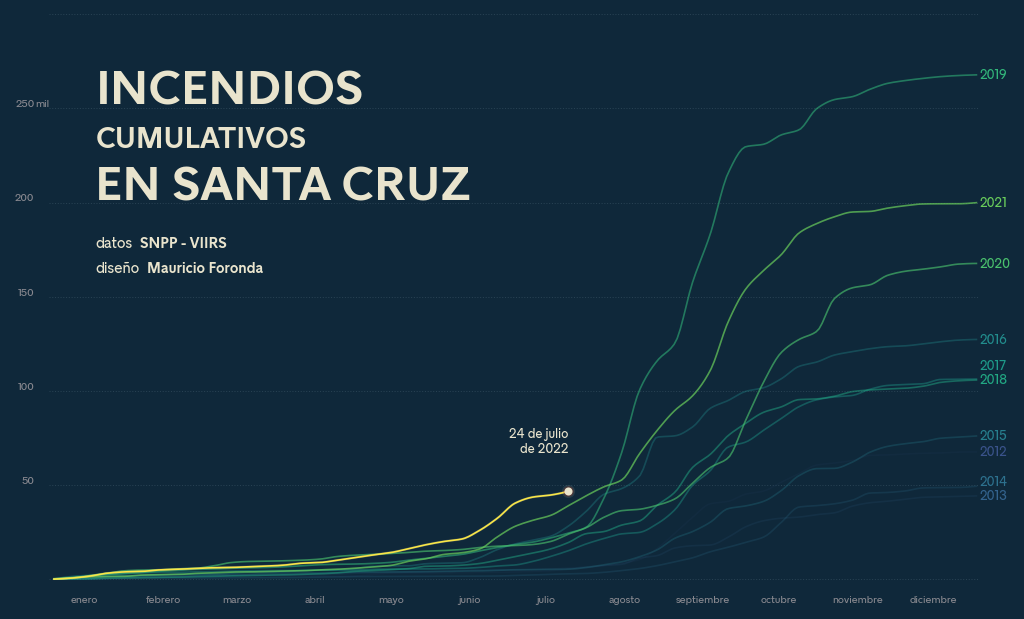

In [270]:
plot_incendios(
    santacruz_semanal,
    last_day="24 de julio\nde 2022",
    filename="incendios_santacruz_semanal.png",
)

Me gusta más esta versión con líneas suavizadas por el aspecto orgánico que ganan en esta paleta de colores. Casi como un niño corriendo sin control con una tenaza incandescente a mitad de una selva. Elegante y encantador, pero en tensión.

Este gráfico puede ser reproducido inmediatamente con datos nuevos, otro departamento, otra paleta de colores o un texto distinto. Por ejemplo, el mismo gráfico para Beni:

In [107]:
beni = filter_incendios("Beni")
beni_diario = daily_fires(beni)
beni_semanal = (
    beni_diario.reset_index()
    .groupby(pd.Grouper(key="date", freq="W-MON"))
    .sum()
    .replace(0, np.nan)
)

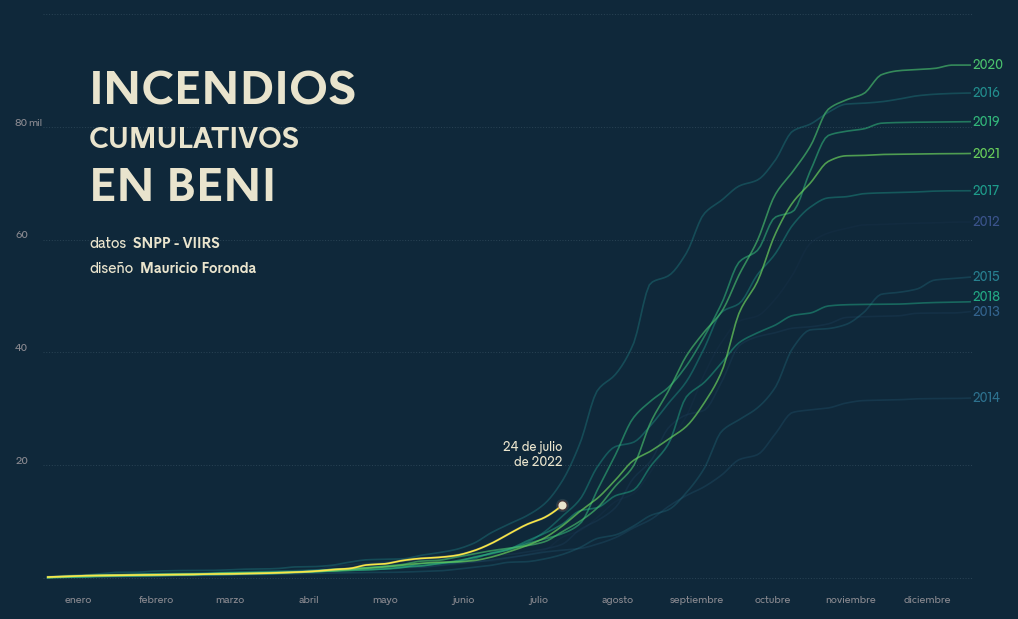

In [106]:
plot_incendios(
    beni_semanal,
    departamento_nombre="Beni",
    filename="incendios_beni.png",
)

O un gráfico sólamente para incendios que ocurren dentro de áreas protegidas:

- [áreas protegidas nacionales, 2018](http://geo.gob.bo/geoserver/ows?service=WFS&request=GetFeature&typeName=sernap:AreaProtegida_Nacional_2018&outputFormat=application/json)
- [áreas protegidas departamentales, 2015](http://geo.gob.bo/geoserver/ows?service=WFS&request=GetFeature&typeName=sernap:areas_protegidas_departamentales42015&outputFormat=application/json)
- [áreas protegidas municipales, 2015](http://geo.gob.bo/geoserver/ows?service=WFS&request=GetFeature&typeName=sernap:areas_protegidas_municipales042015&outputFormat=application/json)

In [205]:
ap = pd.concat(
    [
        gpd.read_file("data/{}.json".format(filename))[columnset].set_axis(['nombre', 'geometry'], axis=1)
        for filename, columnset in zip(
            [
                "areasprotegidas_nacionales",
                "areasprotegidas_departamentales",
                "areasprotegidas_municipales",
            ],
            [
                ["NOMBRE_AP_", "geometry"],
                ["nombre", "geometry"],
                ["nombre", "geometry"],
            ],
        )
    ]
)

In [209]:
en_ap = gpd.sjoin(
    incendios,
    ap,
    how="inner",
    predicate="within",
)

ap_diario = daily_fires(en_ap)
ap_semanal = ap_diario.reset_index().groupby(pd.Grouper(key="date", freq="W-MON")).sum()

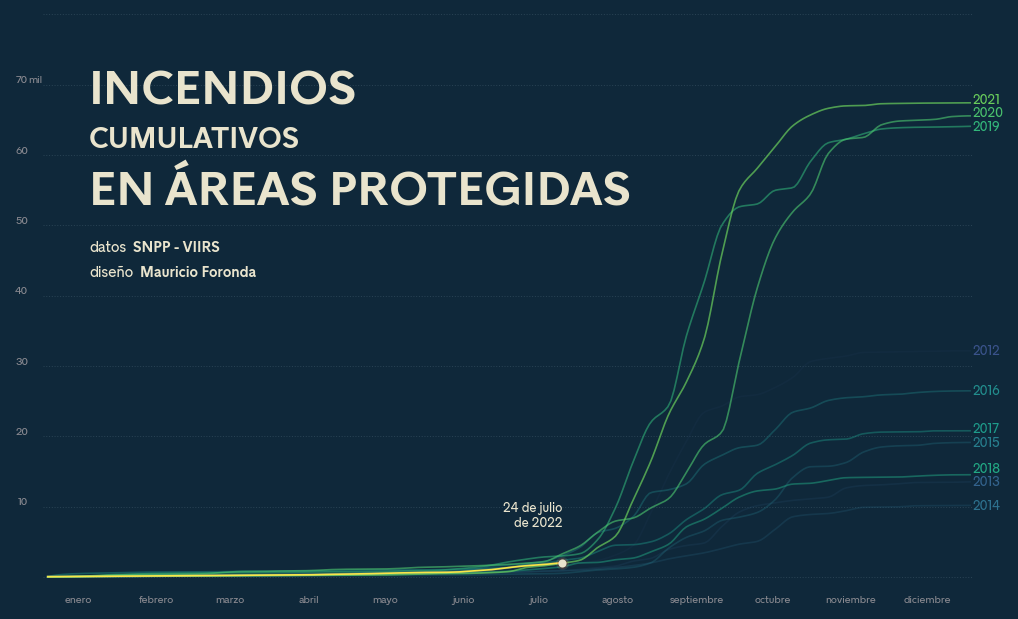

In [210]:
plot_incendios(
    ap_semanal,
    departamento_nombre="áreas protegidas",
    filename="incendios_areas_protegidas.png",
)

_En qué áreas protegidas ocurrieron más incendios desde 2012?_

Una gráfica simple de incendios anueales por área protegida, sólo considerando áreas donde hubieron al menos 500 incendios desde 2012.

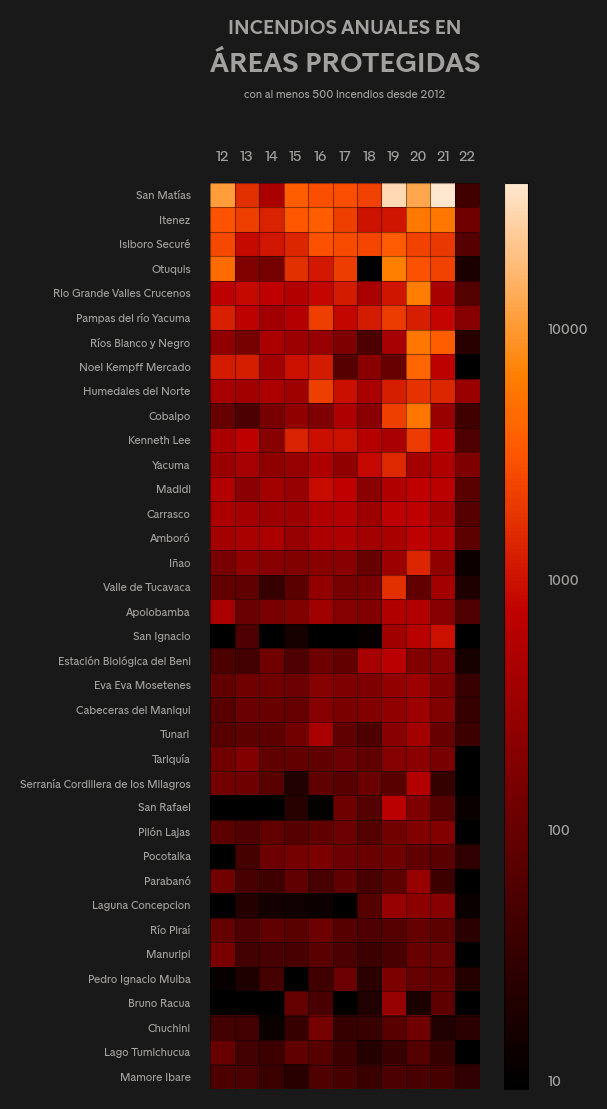

In [310]:
def plot_incendios_anuales_areas_protegidas(en_ap, al_menos_en_total=500, filename=None):
    
    por_area = (
        en_ap.groupby(["year", "nombre"])
        .size()
        .reset_index(name="value")
        .pivot_table(index="nombre", columns="year", values="value")
        .fillna(0)
        .astype(int)
    )
    
    area_ranking = por_area.sum(axis=1).sort_values(ascending=False)
    por_area = por_area.loc[area_ranking.index]
    por_area = por_area[area_ranking >= al_menos_en_total]

    cmap = colors.ListedColormap(cm.get_cmap("gist_heat")(np.linspace(0.0, 0.95, 255)))
    background = colors.to_hex(cmap(0)) + 'e5'
    annotation_color = '#a3a19e'
    f, ax = plt.subplots(1, 1, figsize=(6, 6), dpi=200)
    for i in [f, ax]:
        i.set_facecolor(background)
    im = ax.imshow(
        por_area + 0.1,
        cmap=cmap,
        norm=colors.LogNorm(vmin=10, vmax=por_area.max().max()),
        alpha=1.,
    )
    for axis, side, names in zip(
        [ax.yaxis, ax.xaxis], por_area.shape, [por_area.index, por_area.columns]
    ):
        axis.set_minor_locator(ticker.IndexLocator(1, 0))
        axis.set_major_locator(ticker.FixedLocator([i for i in range(side)]))
        axis.set_major_formatter(ticker.FixedFormatter(names))
    ax.grid(which="minor", linestyle="-", color=background, linewidth=0.4)
    ax.tick_params(labelsize=5, labelcolor=annotation_color, labeltop=True,labelbottom=False)
    ax.tick_params(axis='y', labelsize=4)
    f.canvas.draw()
    ax.set_xticklabels([y.get_text()[-2:] for y in ax.get_xticklabels()])

    axbar = ax.inset_axes([1.09, 0, .09, 1])
    cbar = ax.figure.colorbar(im, cax=axbar, orientation="vertical")
    cbar.outline.set_color(background)
    cbar.outline.set_linewidth(.4)
    cbar.ax.tick_params(labelsize=5, labelcolor=annotation_color)
    for label in cbar.ax.get_yticklabels():
        label.set_va('bottom')
    cbar.ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.0f'))

    axtitle = ax.inset_axes([0, 1, 1, .18])
    axtitle.patch.set_alpha(0.0)
    axtitle.set_axis_off()
    top_title = 1.
    margin_title = .08
    for text, fontsize, weight in zip(['incendios anuales en'.upper(), 'áreas protegidas'.upper(), 'con al menos {} incendios desde 2012'.format(al_menos_en_total)], [7, 10, 4], ['bold', 'bold', 'normal']):
        annotation = axtitle.annotate(text, xy=(.5,top_title), xycoords='axes fraction', color=annotation_color, ha='center', va='top', fontweight=weight, fontsize=fontsize)
        annotation_coords = axtitle.transData.inverted().transform(
                annotation.get_window_extent(renderer=f.canvas.get_renderer())
            )
        top_title = annotation_coords[0][1] - margin_title
        
    if filename is not None:
        f.savefig(
            "plots/{}".format(filename), bbox_inches="tight", pad_inches=0.2, dpi=300
        )
        
plot_incendios_anuales_areas_protegidas(en_ap, 500, 'por_area.png')

Finalmente,

_Dónde exactamente han ocurrido incendios en la última década? Es posible observar una "frontera" agrícola que penetra la amazonía?_

Utilizando los mismos colores por año que en los gráficos anteriores, construyo mapas para Santa Cruz, Beni y Bolivia donde cada punto es un incendio y su color indica el año de registro.

In [101]:
def plot_mapa(tabla_incendios, filename):

    background = "#0f283a"
    colormap = "viridis"
    dfi = tabla_incendios.copy()

    dfi["year"] = dfi.acq_date.dt.year

    current_year = dfi.year.max()
    cmap = colors.ListedColormap(cm.get_cmap(colormap)(np.linspace(0.2, 0.7, 255)))
    palette = {
        year: colors.to_hex(cmap((current_year - year) / (current_year - 2012)))
        for year in sorted(dfi.year.unique())
    }
    palette[current_year] = colors.to_hex(cm.get_cmap(colormap)(1.0))
    dfi.year = dfi.year.astype("category")

    canvas = ds.Canvas(1200, 1200)
    agg = canvas.points(dfi, "longitude", "latitude", ds.count_cat("year"))
    image = ds.tf.shade(agg, color_key=palette, how="eq_hist")
    return export_image(image, "plots/{}".format(filename), background=background)

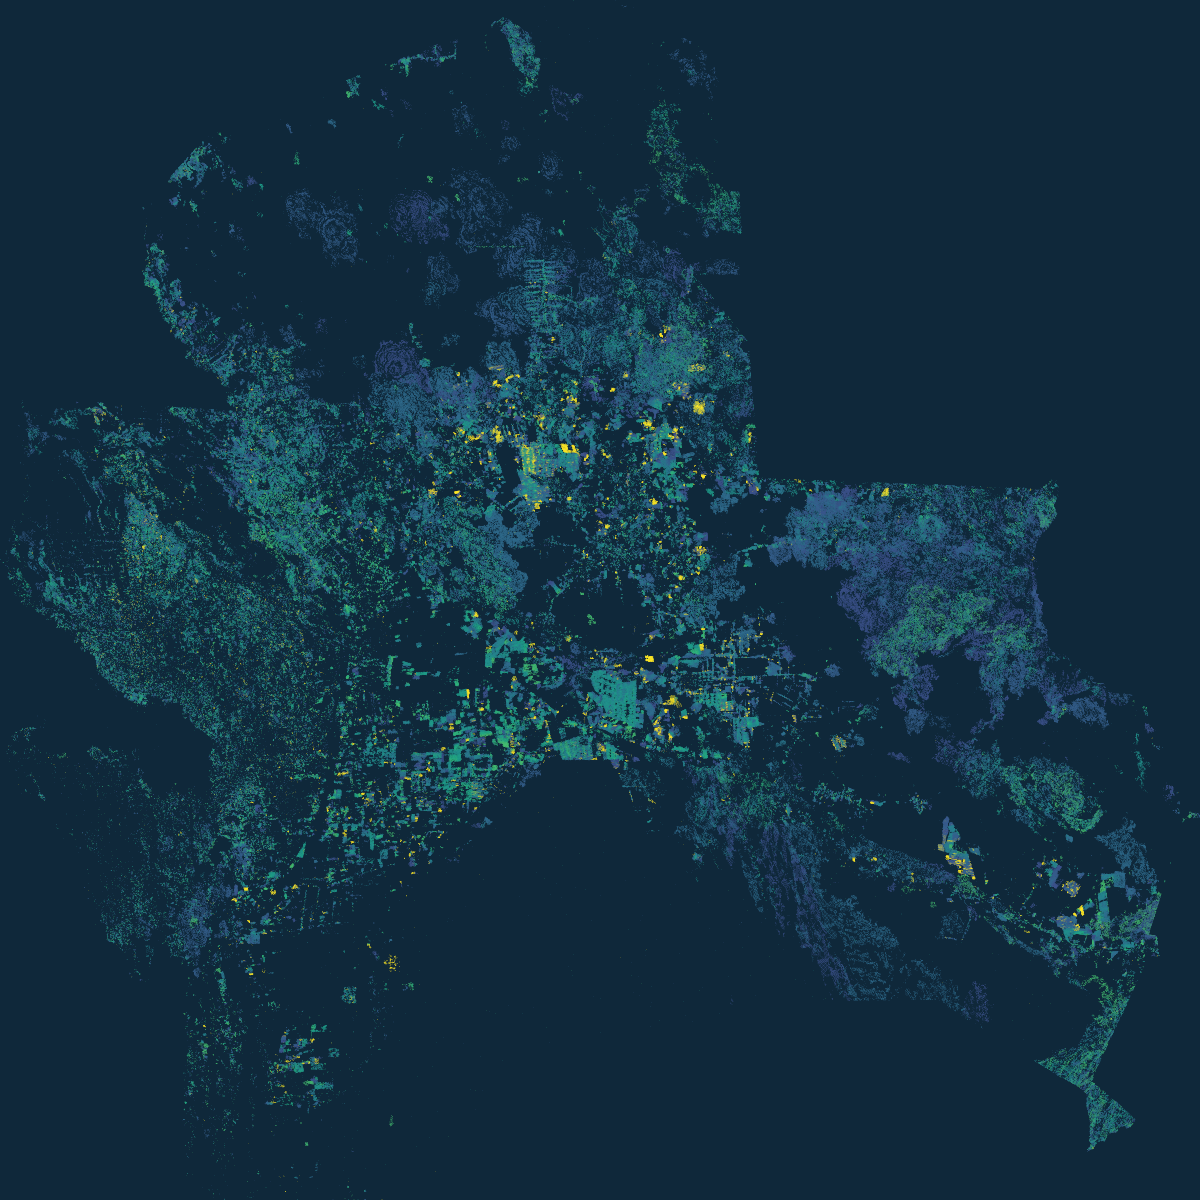

In [102]:
plot_mapa(santacruz, "mapa_santacruz")

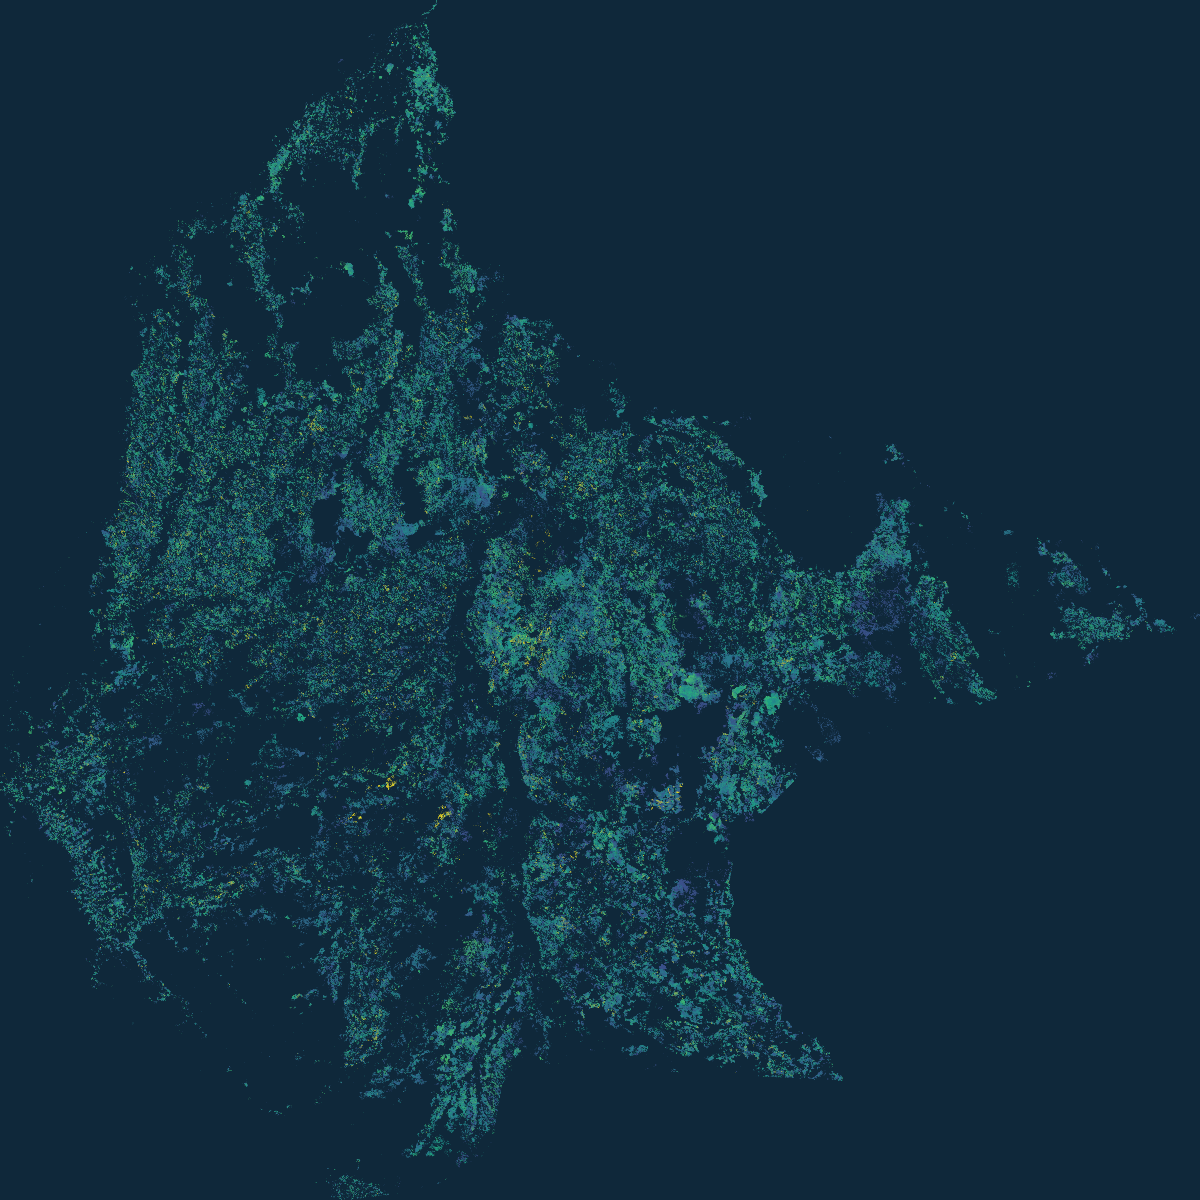

In [108]:
plot_mapa(beni, "mapa_beni")

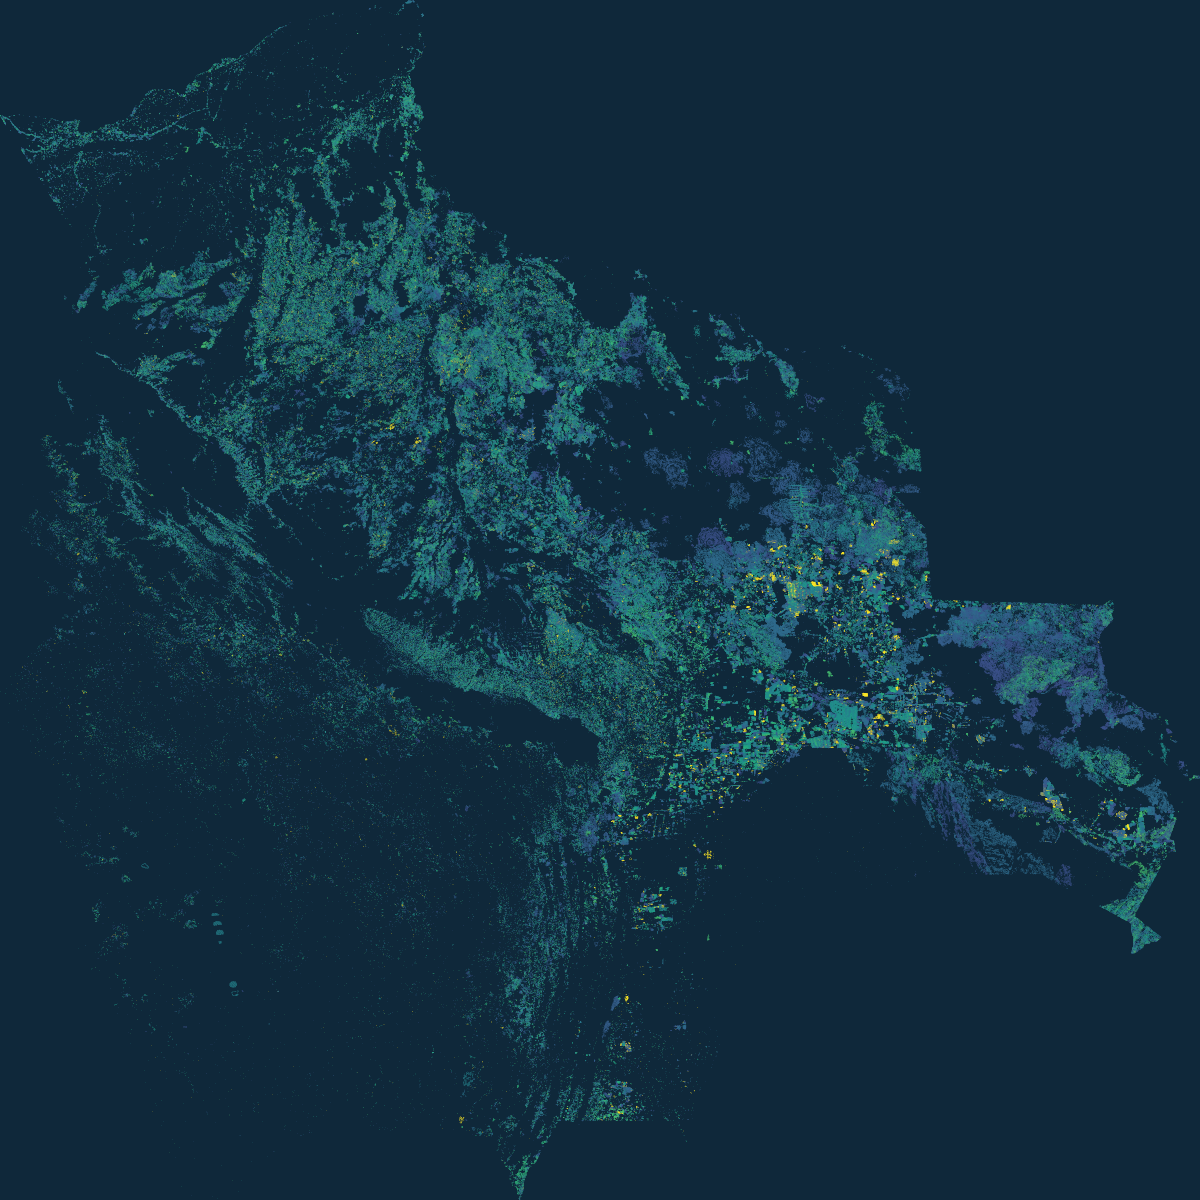

In [103]:
plot_mapa(incendios, "mapa_bolivia")